# Analyzing NYC High School Data

The [SAT](https://en.wikipedia.org/wiki/SAT), or Scholastic Aptitude Test, is a test that high school seniors in the U.S. take every year. The SAT has three sections, each of which is worth a maximum of 800 points. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.

New York City has published the following data on student SAT scores by high school, along with additional demographic data sets:

- SAT scores by school - SAT scores for each high school in New York City
- School attendance - Attendance information for each school in New York City
- Class size - Information on class size for each school
- AP test results - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
- Graduation outcomes - The percentage of students who graduated, and other outcome information
- Demographics - Demographic information for each school
- School survey - Surveys of parents, teachers, and students at each school

New York City has a significant immigrant population and is very diverse, so comparing demographic factors such as race, income and gender with SAT scores can be an interesting way to determine whether the SAT is a fair test. For example, if certain racial groups consistently perform better on the SAT, we would have some evidence that the SAT may be unfair. This will be the goal of our analysis.

### Summary of Results

After analyzing the data, we reached the conclusion that although income was not a variable that we were able to extract, we determined that the groups of schools scoring higher in safety appear to have the highest SAT scores. The safest schools seem to be concentrated in Brooklyn. Furthermore, the percentage of white students in a shool seems to be moderately positively correlated with the average SAT score of that school. On the other hand, the percentage of hispanic students in a shool seems to be moderately negatively correlated with the average SAT score of that school. After a bit of research we found out that the schools with higher percentage of hispanics appear to primarily be geared towards recent immigrants to the US. These schools have a lot of students who are learning English, which would explain the lower SAT scores. The percentage of female students in a shool seems to be moderately positively correlated with the average SAT score of that school. On the other hand, the percentage of male students in a shool seems to be moderately negatively correlated with the average SAT score of that school. We also determined that there was no correlation between percentage of AP test takers and average SAT scores. Finally, the average size of a class in a shool seems to be moderately positively correlated with the average SAT score of that school. This means that the schools with bigger classes perform better on the SATs.

## Reading in the Data

In [1]:
import pandas as pd
import numpy
import re

# Creating list of datasets collected to simplify reading process 
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

# Reading datasets into a dictionary for easier referencing
data = {}

for files in data_files:
    read_file = pd.read_csv("Schools/{0}".format(files))
    data[files.replace(".csv", "")] = read_file

## Reading in the Surveys

There are 2 surveys that originally came from [a survey of parents, teachers, and students](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8). Since they are in a different format, we will have to read them in differently.

In [2]:
# Reading datasets with different format and encoding
all_survey = pd.read_csv("Schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("Schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

# Standardizing name of District Borough Number column
survey["DBN"] = survey["dbn"]

# Listing relevant survey fields for future referencing
survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]

# Adding relevant survey fields to data dictionary
survey = survey.loc[:,survey_fields]
data["survey"] = survey

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


## Adding DBN Columns

The `class_size` dataframe seems to be missing a DBN column. Instead, this information is separated into several different columns (`CSD` and `SCHOOL CODE` columns). We simply need to combine these two columns to form the new `DBN` column. However, the `CSD` column seems to be inconsistent in terms of length of each entry so we will create a function that will fix this and apply it onto that column.

In [3]:
# Standardizing DBN column by capitalizing letters
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

# Creating function to apply onto the class_size dataframe to fix length issue
def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)

# Creating DBN column by combining 2 different columns
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

## Converting Columns to Numeric

In order to be able to work with our data and carry out operations, we need all our entries to be numeric.

In [4]:
# Converting columns to numeric type
cols1 = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols1:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")
    
cols2 = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols2:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

Our `sat_results` dataframe is missing the total SAT score. We can calculate this by adding the score for the 3 subjects the SAT tests students on.

In [5]:
data['sat_results']['sat_score'] = data['sat_results'][cols1[0]] + data['sat_results'][cols1[1]] + data['sat_results'][cols1[2]]

Finally, since the latitude and longitude columns are combined in one column and not in numeric form, we will need to carry out several operations to fix this.

In [6]:
# Creating function to extract latitude from string
def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

# Creating function to extract longitude from string
def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

# Applying functions to mixed column and creating new columns to separate latitude and longitude
data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

# Converting new columns to numeric type
data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

## Condensing Datasets

Since we want to merge all the dataframes using the `DBN` column, we have to make sure all current dataframes do not have duplicate DBN values. In order to make this happen, we will need to condense the dataframes to make sure each row contains a unique DBN value.

The first issue is the `class_size` dataframe. Since we want to work with high schools in this context, we're only concerned with grades 9 through 12. That means we only want to pick rows where the value in the `class_size`'s `GRADE` column is `09-12`. Furthermore, because `GEN ED` is the most popular category by far, we will only select rows where `PROGRAM TYPE` is `GEN ED`.

In [7]:
# Filtering data in class_size dataframe
class_size = data["class_size"] # Temporarily assigning dataframe to new variable to simplify modifications
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size # Re-assigning new variable to original dataframe to make modifications count

We also noticed that the demographics data is split into several school years, we will pick the `20112012` school year as this will give us the most recent year of data, and also match our SAT results data.

In [8]:
# Filtering school year
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

The Demographic and Cohort columns are what prevent DBN from being unique in the graduation data. A Cohort appears to refer to the year the data represents, and the Demographic appears to refer to a specific demographic group. In this case, we want to pick data from the most recent `Cohort` available, which is `2006`. We also want data from the full cohort, so we'll only pick rows where `Demographic` is equal to `Total Cohort`.

In [9]:
# Filtering graduation dataframe
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

## Combining the Datasets

We can now merge our dataframes to perform analyses. We'll merge two data sets at a time. Because this project is concerned with determing demographic factors that correlate with SAT score, we'll want to preserve as many rows as possible from `sat_results` while minimizing null values.

This means that we may need to use different merge strategies with different data sets. Some of the data sets have a lot of missing `DBN` values. This makes a `left` join more appropriate, because we don't want to lose too many rows when we merge. Some data sets have `DBN` values that are almost identical to those in `sat_results`. Those data sets also have information we need to keep. Most of our analysis would be impossible if a significant number of rows was missing from demographics, for example. Therefore, we'll do an `inner` join to avoid missing data in these columns.

In [10]:
# Creating dataset for merging
combined = data["sat_results"]

# Merging 2 at a time using left merge
combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

# Merging using list and inner merge
to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

## Adding a School District Column for Mapping

We've finished cleaning and combining our data. We now have a clean data set on which we can base our analysis. Mapping the statistics out on a school district level might be an interesting way to analyze them. Adding a column to the data set that specifies the school district will help us accomplish this.

The school district is just the first two characters of the `DBN`. We can apply a function over the `DBN` column of combined that pulls out the first two letters.

In [11]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## Finding Correlations

Because we're interested in exploring the fairness of the SAT, a strong positive or negative correlation between a demographic factor like race or gender and SAT score would be an interesting result meriting investigation. If men tended to score higher on the SAT, for example, that would indicate that the SAT is potentially unfair to women, and vice-versa.

We can use the pandas `pandas.DataFrame.corr()` method to find correlations between columns in a dataframe. The method returns a new dataframe where the index for each column and row is the name of a column in the original data set.

In [12]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

## Plotting Survey Correlations

Now that we have an overview of all correlations with `sat_score`, we can start by verifying visually which fields from the surveys have the highest correlations with the SAT score.

In [13]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

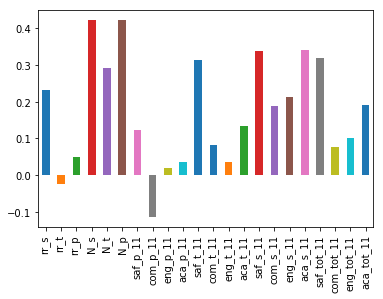

In [14]:
# Set up matplotlib to work in Jupyter notebook
%matplotlib inline

# Plot correlations between survey fields and sat_score
correlations[survey_fields].plot.bar()

The highest correlations seem to be with `N_s` and `N_p` which, according to the [data dictionary](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8), are the number of student respondents and parent respondents. These two columns are irrelevant to our analysis. Moving on, `saf_t_11` and `saf_s_11`, which measure how teachers and students perceive safety at school, correlated moderately with `sat_score`. All other highly correlating columns are irrelevant to the analysis.

## Exploring Safety and SAT Scores

Next, we'll dig into this relationship a bit more, and try to figure out which schools have low safety scores.

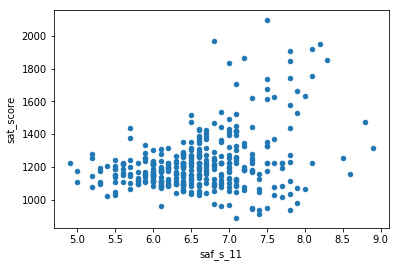

In [15]:
# Create scatter plot of safety vs sat score in combined dataframe
combined.plot.scatter(x="saf_s_11", y="sat_score")

There seems to be a trend that the groups of schools scoring higher in safety appear to have the highest sat scores. 

In [16]:
# Computing average safety score for each district
district_combined = combined.groupby("school_dist").agg(numpy.mean)

district_combined["saf_s_11"].head()

school_dist
01    6.768611
02    6.910660
03    6.716667
04    6.885714
05    6.314286
Name: saf_s_11, dtype: float64

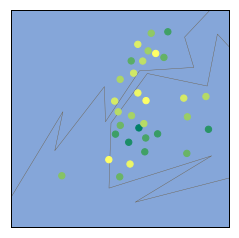

In [17]:
# Mapping out NYC
from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='l'
    )
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F00', linewidth=.4)

# Converting longitudes and latitudes to list
longitudes = district_combined["lon"].tolist()
latitudes = district_combined["lat"].tolist()
    
# Mapping out safety score by district
m.scatter(longitudes, latitudes, s=40, zorder=2, latlon=True, c=district_combined["saf_s_11"], cmap="summer")

The safest schools seem to be concentrated in Brooklyn.

## Exploring Race and SAT Scores

Next, we'll investigate racial differences in SAT scores.

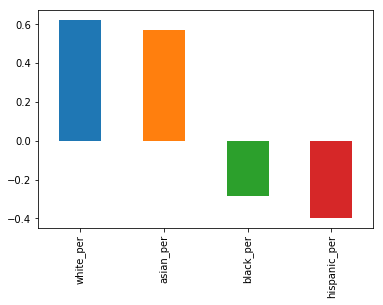

In [18]:
# Plot correlations between races and sat_score
correlations[["white_per", "asian_per", "black_per", "hispanic_per"]].plot.bar()

The percentage of white students in a shool seems to be moderately positively correlated with the average SAT score of that school. On the other hand, the percentage of hispanic students in a shool seems to be moderately negatively correlated with the average SAT score of that school.

We can now explore schools with low SAT scores and high percentages of hispanics by plotting a scatter plot.

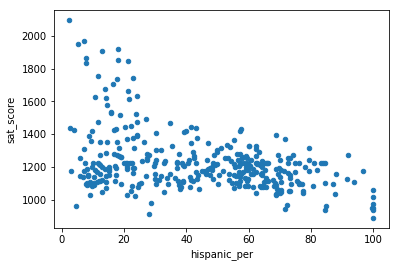

In [19]:
# Create scatter plot of percentage of hispanics vs sat score in combined dataframe
combined.plot.scatter(x="hispanic_per", y="sat_score")

Using the scatter plot, we can observe that there are several schools that have 100% of hispanics and very low SAT scores. We can dig deeper and research the names of the schools with a percentage of hispanics higher than 95%. Could there be anything interesting about these particular schools?

In [20]:
# Filtering school names with percentage of hispanics higher than 95%
high_hispanics = combined[combined["hispanic_per"] > 95]["SCHOOL NAME"]
high_hispanics.head()

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
Name: SCHOOL NAME, dtype: object

After a bit of research we find out that most of them are public schools and have hispanic affiliations in their creation. The schools listed above appear to primarily be geared towards recent immigrants to the US. These schools have a lot of students who are learning English, which would explain the lower SAT scores. We can now try filtering schools with a percentage of hispanics less than 10% and an average SAT score greater than 1800 to see how these schools compare.

In [21]:
# Filtering school names with percentage of hispanics higher than 95%
low_hispanics = combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]["SCHOOL NAME"]
low_hispanics.head()

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Most of the schools that appear when filtering this certain way are specialized high schools–high schools that prepare for college/university.

## Exploring Gender and SAT Scores

There are two columns that indicate the percentage of each gender at a school:

- male_per
- female_per

We can plot out the correlations between each percentage and SAT scores.

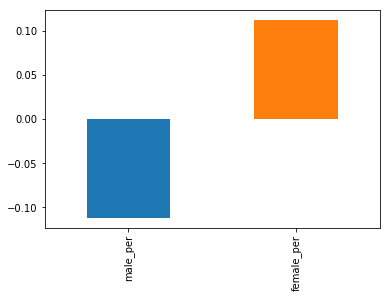

In [22]:
# Plot correlations between gender and sat_score
correlations[["male_per", "female_per"]].plot.bar()

The percentage of female students in a shool seems to be moderately positively correlated with the average SAT score of that school. On the other hand, the percentage of male students in a shool seems to be moderately negatively correlated with the average SAT score of that school.

We can now dig deeper and investigate schools with high SAT scores and a high percentage of females.

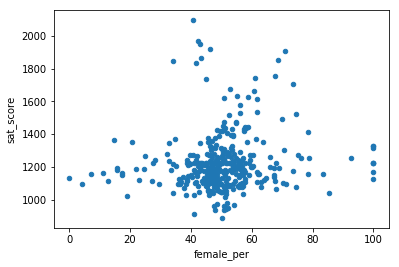

In [23]:
# Create scatter plot of percentage of females vs sat score in combined dataframe
combined.plot.scatter(x="female_per", y="sat_score")

Based on the scatterplot, there doesn't seem to be any real correlation between sat_score and female_per. However, there is a cluster of schools with a high percentage of females (60 to 80), and high SAT scores. We can dig deeper and research the names of the schools with a percentage of females higher than 60% and an average SAT score greater than 1700. Could there be anything interesting about these particular schools?

In [24]:
# Filtering school names with percentage of females higher than 60%
high_females = combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]["SCHOOL NAME"]
high_females.head()

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

These schools appears to be very selective liberal arts schools.

## Exploring AP Test Takers and SAT Scores

In the U.S., high school students take Advanced Placement (AP) exams to earn college credit. There are AP exams for many different subjects.

It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. Let's explore this relationship. Because `total_enrollment` is highly correlated with `sat_score`, we don't want to bias our results. Instead, we'll look at the percentage of students in each school who took at least one AP exam.

In [25]:
# Calculating percentage of AP test takers, creating new column
combined["ap_per"] = combined["AP Test Takers "]/combined["total_enrollment"] * 100

# Exploring modified dataframe
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist,ap_per
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,0,0,0,0,0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260,01,30.575556
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0,0,0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797,01,9.898477
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,0,0,0,0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041,01,3.177258
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,0,129.028846,197.038462,...,0,0,0,0,0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673,01,35.157724
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,0,0,0,0,0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426,01,15.809051


We can first quickly check the correlation coefficient.

In [26]:
combined["sat_score"].corr(combined["ap_per"])

0.05717081390766968

Visualizing the data may help determine trends.

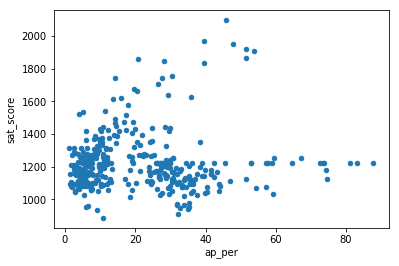

In [27]:
# Plotting percentage of AP test takers vs SAT scores in combined dataframe
combined.plot.scatter(x="ap_per", y="sat_score")

The plot shows us that there seems to be a very slight trend that schools with a higher percentage of AP test takers have higher SAT scores. However, when looking at schools with percentage of AP test takers over 60%, we notice that there is no difference in the average SAT score amongst them. Rather, there seems to be a slight negative correlation within this interval.

## Exploring Class Size and SAT Scores

Finally, we can determine whether there is a correlation between the average size of classes in a school and their average SAT score. Prior to performing the analysis, we would think that schools with larger classes will have lower scores than their counterparts since a lower student to teacher ratio means that students would get much more personalized help along the way to prepare for their SATs.

We can first quickly check the correlation coefficient.

In [28]:
combined["sat_score"].corr(combined["AVERAGE CLASS SIZE"])

0.38101433080955244

The average size of a class in a shool seems to be moderately positively correlated with the average SAT score of that school. This means that the schools with bigger classes perform better on the SATs. To better understand trends, we can plot this.

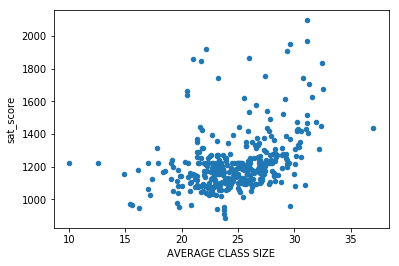

In [29]:
# Plotting percentage of avg class size vs SAT scores in combined dataframe
combined.plot.scatter(x="AVERAGE CLASS SIZE", y="sat_score")

We don't observe anything in particular in this scatterplot other than the fact that the smallest classes (<20) score quite low on the SAT (<1300).

## Conclusion

The goal of this project was to compare demographic factors such as race, income, and gender with SAT scores in order to determine if the SAT is a fair test. 

Although income was not a variable that we were able to extract, we determined that the groups of schools scoring higher in safety appear to have the highest SAT scores. The safest schools seem to be concentrated in Brooklyn. Furthermore, the percentage of white students in a shool seems to be moderately positively correlated with the average SAT score of that school. On the other hand, the percentage of hispanic students in a shool seems to be moderately negatively correlated with the average SAT score of that school. After a bit of research we found out that the schools with higher percentage of hispanics appear to primarily be geared towards recent immigrants to the US. These schools have a lot of students who are learning English, which would explain the lower SAT scores. The percentage of female students in a shool seems to be moderately positively correlated with the average SAT score of that school. On the other hand, the percentage of male students in a shool seems to be moderately negatively correlated with the average SAT score of that school. We also determined that there was no correlation between percentage of AP test takers and average SAT scores. Finally, the average size of a class in a shool seems to be moderately positively correlated with the average SAT score of that school. This means that the schools with bigger classes perform better on the SATs.

Further analyses could look at other demographic factors such as income using additional data sources.